# Link to notebook - http://esriurl.com/hubBikeAnalysis


# Diagnosing bike street accidents of DC

The purpose of this notebook is to delve deeper to gain a deeper understanding of the nature of bike crashes, using the `Crashes In DC` and `Crash Details Table` datasets of DC. Here, we'll see

> 1. A map highlighting the __magnitude of bike accidents__ in DC

> 2. Assessing if all these __accidents happen on dedicated bike lanes__

> 3. Learning some more about the __nature of these bike crashes__ 

### _But why should I care?_

> * According to the American Community Survey, about __13,000 D.C. residents bike to work each day__, with an increase of 1,200 new cyclists each year.


> * In 2015, __bicyclists had the largest increase of fatalities (over 800, ie 12%)__ among all the roadway user groups, including drivers and pedestrian


> * Only __53% of all fatal bike crashes get reported in newspapers__, and usually as only one story about the fatal crash itself. 

In [1]:
import pandas as pd

The crash data for DC is collected in two separate tables

> 1. __`Crashes in DC`__ - providing location and injury data for the crashes

> 2. __`Crash Details Table`__ providing supplementary data about the people and vehicles involved in the crash


Datasets used here can be found on [opendata.dc.gov](http://opendata.dc.gov/)

### Reading in the DC crash dataset

In [2]:
#Reading 'Crashes in DC'
crash = pd.read_csv('D:\Data\Crashes_In_DC\Crashes_in_DC.csv', low_memory=False)
crash.shape

(140773, 49)

Let's now explore the various fields in the `crash` table

In [3]:
crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140773 entries, 0 to 140772
Data columns (total 49 columns):
X                             140106 non-null float64
Y                             140106 non-null float64
OBJECTID                      140773 non-null int64
CRIMEID                       140773 non-null int64
CCN                           140773 non-null object
REPORTDATE                    139736 non-null object
ROUTEID                       140144 non-null object
MEASURE                       140144 non-null float64
OFFSET                        140144 non-null float64
STREETSEGID                   140144 non-null float64
ROADWAYSEGID                  140144 non-null float64
FROMDATE                      140773 non-null object
TODATE                        0 non-null float64
MARID                         140773 non-null int64
ADDRESS                       140745 non-null object
LATITUDE                      140773 non-null float64
LONGITUDE                     140773 non-

In [4]:
crash.head()

X          Y  OBJECTID   CRIMEID       CCN  \
0 -77.012152  38.919710  18335710  26614138  11024141   
1 -77.012158  38.915732  18335711  26614272  11020933   
2 -77.012145  38.926289  18335712  27266870  17054267   
3 -77.012177  38.901874  18335713  25171264  14165295   
4 -77.012174  38.900391  18335714  25143825  14052411   

                 REPORTDATE   ROUTEID   MEASURE  OFFSET  STREETSEGID   ...     \
0  2011-02-22T05:00:00.000Z  11000102  3151.632     0.0      10744.0   ...      
1  2011-02-16T05:00:00.000Z  11000102  2709.977     0.0       4878.0   ...      
2  2017-04-04T00:50:44.000Z  11000102  3881.933     0.0      11579.0   ...      
3  2014-10-25T05:00:00.000Z  11000102  1171.651     0.0       1268.0   ...      
4  2014-04-16T05:00:00.000Z  11000102  1006.145     0.0      15414.0   ...      

   BICYCLISTSIMPAIRED DRIVERSIMPAIRED  TOTAL_TAXIS  TOTAL_GOVERNMENT  \
0                   0               0          0.0               0.0   
1                   0               0          0.0               0.0   
2                   0               0          0.0               1.0   
3                   0               0          0.0               0.0   
4                   0               0          0.0               0.0   

  SPEEDING_INVOLVED  NEARESTINTROUTEID  NEARESTINTSTREETNAME  OFFINTERSECTION  \
0               0.0           11009032           ADAMS ST NW        58.541660   
1               0.0           11075462   RHODE ISLAND AVE NW         0.076475   
2               0.0           11060582       MICHIGAN AVE NW         0.034064   
3               0.0           11047772               I ST NW        60.933379   
4               0.0           11042442               H ST NW        20.706903   

   INTAPPROACHDIRECTION LOCERROR  
0                 South      NaN  
1             Northeast      NaN  
2                 South      NaN  
3                 North      NaN  
4                 North      NaN  

[5 rows x 49 columns]

### 1. A map highlighting the magnitude of bike accidents in DC

The dataset records around __140k__ crashes, mostly from 2015 through September 2017. With an alarming number like that, let's see how frequent bike accidents are. 

Here, we'll plot a heatmap using the Python package Bokeh, to qualitatively gauge the frequency of bike crashes in DC.

In [5]:
#Importing necessary packages
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader import transfer_functions as tf
from datashader.colors import colormap_select, Greys9, Hot, inferno
Greys9_r = list(reversed(Greys9))[:-2]

C:\Users\manu9321\AppData\Local\Continuum\Anaconda3\lib\site-packages\odo\backends\pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


We start by creating an empty plot container

In [6]:
output_notebook()

DC = x_range, y_range = ((-77.113633,-76.910012), (38.812061,38.993699))

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    p.add_tools(BoxZoomTool(match_aspect=True))
    
    return p
    
options = dict(line_color=None, fill_color='blue', size=5)

Loading BokehJS ...

Let's now create a column in the table, `BIKE_TOTAL`, that records all the bike injuries/fatalities.

In [7]:
crash['BIKE_TOTAL'] = crash['MAJORINJURIES_BICYCLIST'] + crash['MINORINJURIES_BICYCLIST'] + crash['UNKNOWNINJURIES_BICYCLIST'] + crash['FATAL_BICYCLIST'] + crash['BICYCLISTSIMPAIRED']

In [8]:
background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(crash, 'X', 'Y',  ds.count('BIKE_TOTAL'))
    img = tf.shade(agg, cmap=Hot, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image(*DC),"DC_bikeCrashes")
InteractiveImage(p, create_image)

![dc_bikecrashes](https://user-images.githubusercontent.com/13968196/36805091-75524684-1c8a-11e8-8ce5-6c60ae1b053f.png)

This map indicates a high volume of bike crashes occuring in DC, much more than imagined!

### 2. Assessing if all these accidents happen on dedicated bike lanes

In [25]:
from arcgis.gis import *
gis = GIS("http://dcdev.maps.arcgis.com/", "username", "password")

The image below shows a representation of 1000 crashes (of all kinds), overlaying the bike lanes. We also notice a large number of crashes in SE DC that do not overlay a bike lane.

Are these car crashes, or bike crashes occuring on non bike-lanes? Let's verify...

![bike_and_crash](https://user-images.githubusercontent.com/13968196/36805089-752ab948-1c8a-11e8-8ebd-d6c6b4e6f462.PNG)

Let's filter the crashes dataset to contain only bike accidents

In [12]:
bike_accidents = crash.loc[crash['TOTAL_BICYCLES'] != 0]
bike_accidents.shape

(1210, 50)

#### 2.1 Publishing a feature layer from a Pandas Dataframe

We will now publish a layer of only accidents involving bikes to Online.

We start by creating a column containing the `SHAPE` of the geometry

In [28]:
bike_accidents['SHAPE'] = bike_accidents.apply(lambda row : arcgis.geometry.Geometry({'x': row['X'], 'y': row['Y']}), axis=1 )

C:\Users\manu9321\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
#Importing package
from arcgis import SpatialDataFrame

In [29]:
bike_sdf = SpatialDataFrame(bike_accidents)
bike_sdf.set_geometry('SHAPE', inplace=True, sr=4326)
bike_sdf['SHAPE'] = bike_sdf.geometry.project_as(4326)
bike_sdf.shape

(1210, 50)

In [30]:
#Publish the data
bikeCrash_layer = gis.content.import_data(bike_sdf, title='bikeCrashes_1', target_sr=4326, capabilities="Query,Editing")

The following rows could not be written to the table: 2777,2805,140098


In [31]:
bikeCrash_layer

<Item title:"bikeCrashes_1" type:Feature Layer Collection owner:mmajumdar_dcdev>

#### 2.2 Publishing a feature layer from a Shapefile

In [43]:
data = "Bicycle_Lanes.zip"
shpfile = gis.content.add({}, data)

In [44]:
published_service = shpfile.publish()
display(published_service)

<Item title:"Bicycle_Lanes" type:Feature Layer Collection owner:mmajumdar_dcdev>

<Item title:"BikeCrashes_WithLanes" type:Web Map owner:mmajumdar_dcdev>
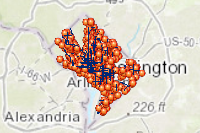

In [45]:
#Viewing the map
search_result = gis.content.search("BikeCrashes_WithLanes")
search_result[0]

### 3. Learning some more about the nature of these bike crashes

Here we'll look at the `Crash_Details_Table` that contains other details about crashes

In [9]:
crash_details = pd.read_csv('D:\Data\Crashes_In_DC\Crash_Details_Table.csv', low_memory=False)
crash_details.shape

(316682, 15)

In [10]:
crash_details.head()

OBJECTID   CRIMEID       CCN  PERSONID PERSONTYPE   AGE FATAL MAJORINJURY  \
0  36004281  25298353  15095133  85048959     Driver   NaN     N           N   
1  36004282  25300074  15097124  84722776     Driver  34.0     N           N   
2  36004283  25300074  15097124  84588227     Driver   NaN     N           N   
3  36004284  25301094  15098391  84851675     Driver   NaN     N           N   
4  36004285  25058695  14104914  84895614     Driver  43.0     N           N   

  MINORINJURY VEHICLEID             INVEHICLETYPE TICKETISSUED  \
0           Y    976484  Passenger Car/automobile            N   
1           N    976548  Passenger Car/automobile            N   
2           N    976548  Passenger Car/automobile            N   
3           N    976614  Passenger Car/automobile            N   
4           N    976649              Pickup Truck            N   

  LICENSEPLATESTATE IMPAIRED SPEEDING  
0                DC        N        N  
1                MD        N        N  
2                MD        N        N  
3                VA        N        N  
4                MD        N        N

Let's filter it to contain only bike crashes

In [11]:
bike_crash_details = crash_details.loc[(crash_details['PERSONTYPE']=='Bicyclist') | ((crash_details['PERSONTYPE']=='Pedestrian') & (len(crash_details['LICENSEPLATESTATE'] != 2)))]
bike_crash_details.shape

(1043, 15)

We now create a chart to see the distribution of bicyclists that have crashed, based on age of the bicyclists

In [15]:
#Importing visualization packages of Python
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
%matplotlib inline

In [26]:
def calculate_age_bin(x):
    '''Function that creates an appropriate bin value for each age'''
    try:
        return int(x/10)
    except:
        return int(0)

In [28]:
bike_crash_details['age_counts'] = bike_crash_details['AGE'].apply(calculate_age_bin)
bike_crash_details['age_counts'].head()

C:\Users\manu9321\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


14358     5
77815     2
122008    3
122009    6
122010    2
Name: age_counts, dtype: int64

Text(0,0.5,'Frequency')

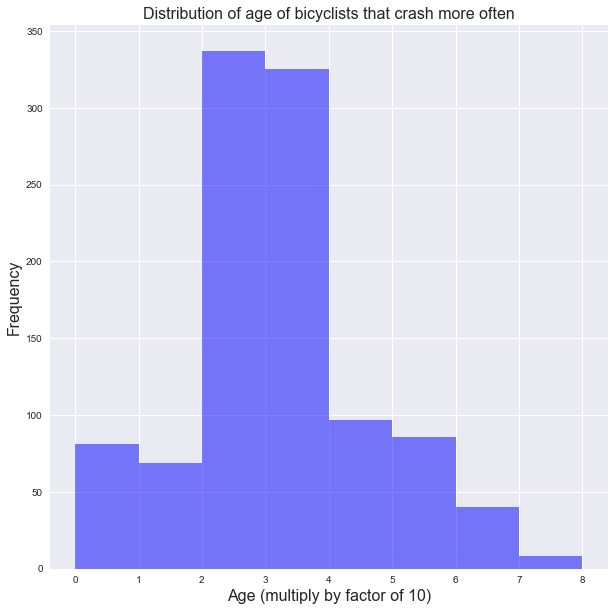

In [67]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(bike_crash_details['age_counts'], bins=[0,1,2,3,4,5,6,7,8], facecolor='blue', alpha=0.5)

plt.title("Distribution of age of bicyclists that crash more often", fontsize=16)
plt.xlabel("Age (multiply by factor of 10)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

Based on this chart we observe that most bicyclists that have met with accidents are within the age range of 20-40 years.

The frequency generated for riders under the age of 10, could also indicate some missing values, defaulting to 0

### What next?

> * Combine this with the Hub Vision Zero intitiative and High Injury Network analysis.


> * Perform deeper analysis with other datasets and propose new bikelane routes to DC Department of Transportation

 
> * Report a crash to [waba.org](http://www.waba.org)


> * As a bicyclist, ensuring that the bike has bells, lights and that you wear a helmet.
